In [84]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader,random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

In [3]:
# path configuration
LABELS_PATH = '../data/train_val_annotation/train_val_videodatainfo.json'
DATA_PATH = '../data/train_val_features/'

In [30]:
import json
from pickle import dump, load

In [5]:
# JSON file
f = open (LABELS_PATH, "r")
  # Reading from file
data = json.loads(f.read())

In [96]:
data['videos'][0]

{'category': 9,
 'url': 'https://www.youtube.com/watch?v=9lZi22qLlEo',
 'video_id': 'video0',
 'start time': 137.72,
 'end time': 149.44,
 'split': 'train',
 'id': 0}

In [7]:
## randomly select sentence
#label_df = pd.DataFrame(data['sentences'])
#label_final_df = label_df.groupby('video_id')['sen_id'].unique().apply(lambda x: x[np.random.randint(0,20)]).to_frame().reset_index()
#label_final_df['video_id'].nunique()
#label_final_df = label_final_df.join(label_df[['sen_id', 'caption']].set_index('sen_id'), on='sen_id')
#label_final_df.to_csv('../data/label_final.csv', index=False)

## DataSet

In [8]:
label_final_df = pd.read_csv('../data/label_final.csv')

### 1. Create embedding matrix from google news word2vec

In [9]:
import spacy
from collections import Counter
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [35]:
# embedding
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))
glove_emb = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [11]:
all_sent = label_final_df['caption'].tolist()#.astype('unicode')

In [26]:
wc = Counter()
try:
    for doc in nlp.pipe(all_sent):
        for word in doc:
            #print(word)
            wc[str(word)] += 1
except Exception as e:
    print(e)
    print(doc,'\nword:', word)

In [51]:
# create embedding matrix
# initialization
EMBEDDING_SIZE = 300
embedding = np.zeros((len(wc)+4, 300)) # +4 for start, end, unk, padding
word2idx = {}
idx2word = {}

word2idx['<PAD>'] = 0
idx2word[0] = '<PAD>'
embedding[0] = np.random.rand(300)*2 - 1

word2idx['<START>'] = 1
idx2word[1] = '<START>'
embedding[1] = np.random.rand(300)*2 - 1

word2idx['<END>'] = 2
idx2word[2] = '<END>'
embedding[2] = np.random.rand(300)*2 - 1

word2idx['<UNK>'] = 3
idx2word[3] = '<UNK>'
embedding[3] = np.random.rand(300)*2 - 1

count = 0
for word, _ in wc.most_common():
    wid = len(word2idx)
    word2idx[word] = wid
    idx2word[wid] = word
    if word in glove_emb:
        embedding[wid] = glove_emb.get_vector(word)
    else:
        embedding[wid] = np.random.rand(300)*2 - 1 # random initialisation (-1, 1)
        count += 1

In [53]:
print(f'{count} words are not in google news werd2vec')

401 words are not in google news werd2vec


In [835]:
np.save('../model/embedding.npy', embedding)

In [988]:
import pickle
with open("../model/word2idx.pkl","wb") as f:
    pickle.dump(word2idx, f)


In [989]:
with open("../model/idx2word.pkl","wb") as f:
    pickle.dump(idx2word, f)

### 2.Dataset Class for pytorch

In [259]:
class MSRVTT(Dataset):
    def __init__(self, df, word2idx, DATA_PATH):
        super(MSRVTT, self).__init__()
        self.df = df
        self.path = DATA_PATH
        self.word2idx = word2idx
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid = row['video_id']
        filename = self.path + f'{vid}-feature.pt5'
        x = torch.load(filename)
        sentence_emb = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in row['caption'].split(' ')]
        y = torch.zeros(len(sentence_emb)+2)
        y[0], y[-1] = self.word2idx['<START>'], self.word2idx['<END>']
        y[1:-1] = torch.tensor(sentence_emb)
        #true_sentence = row['caption']
        y = F.pad(y, pad=(0, 20 - y.shape[0]))
        x = F.pad(x, pad=(0, 0, 40-x.shape[0], 0))
        return x, y.long()#, true_sentence

In [260]:
ds = MSRVTT(label_final_df, word2idx, DATA_PATH)

In [261]:
ds[5] 

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0396, 0.4085, 0.5028,  ..., 0.6331, 0.1015, 0.0470],
         [0.1039, 0.4748, 0.6943,  ..., 0.5652, 0.6987, 0.2298],
         [0.6233, 0.3887, 0.9117,  ..., 0.8732, 0.4357, 0.4482]]),
 tensor([  1,  42,  13, 204,  23, 697,  31,   4, 261, 481,   2,   0,   0,   0,
           0,   0,   0,   0,   0,   0]))

In [250]:
frames_size = []
sents_length = []
for data in ds_iter:
    frames_size.append(data[0].shape[0])
    sents_length.append(len(data[1]))

In [251]:
import matplotlib.pyplot as plt

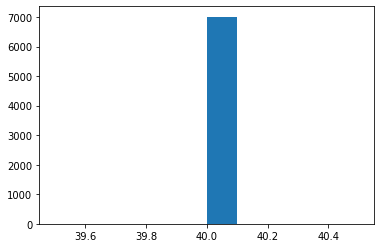

In [252]:
# frames length distribution
plt.hist(frames_size)
plt.show()

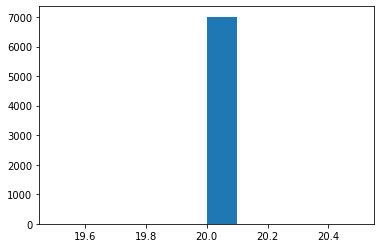

In [253]:
# sentence length distribution
plt.hist(sents_length)
plt.show()

### 3.Dataloaders

In [262]:
# split train/test
train_proportion = 0.93
train_size = int(train_proportion * len(ds))
validation_size = len(ds) - train_size
print(train_size, validation_size)

6519 491


In [263]:
train_ds, validation_ds = random_split(ds, [train_size, validation_size])
# dataloaders
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dl = DataLoader(validation_ds, batch_size=2, shuffle=False)

In [305]:
x, y = next(iter(train_dl))
cnn = nn.Conv1d(40, 10, 5, stride=2)
fc = nn.Linear(5110, 800)
x = F.max_pool1d(F.relu(cnn(x)), 2)
x = torch.flatten(x, 1)
x = x.unsqueeze(0)
x = fc(x)
x.size()

torch.Size([1, 8, 800])

# Model

### Sequence to Sequence Model (Encoder-Decoder)

While image description handles a variable length output sequence of words, video description also has to handle a variable length input sequence of frames. Related approaches to video description have resolved variable length input by holistic video representations [29, 28, 11], pooling over frames [39], or sub-sampling on a fixed number of input frames [43]. In contrast, in this work we propose a sequence to sequence

In [313]:
# from torchvision.models import resnet18, resnet101

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        
        self.cnn = nn.Conv1d(40, 10, 5, stride=2)
        self.fc = nn.Linear(5110, hidden_dim)
        
        
        
    def forward(self, x):
        x = F.max_pool1d(F.relu(self.cnn(x)), 2)
        x = torch.flatten(x, 1)
        x = x.unsqueeze(0)
        x = self.fc(x)
        return x
        
        
    
class Decoder(nn.Module):
    '''
    Decode Hidden State from Encoder to sentence (sequence of texts)
    
    note: batch_first=True does not apply to hidden or cell states
    '''
    def __init__(self, weights, emb_dim, hidden_dim, out_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.out_dim = out_dim
        
        # layers
        self.emb = nn.Embedding.from_pretrained(torch.tensor(weights), padding_idx=0, freeze=False)
        self.rnn = nn.GRU(emb_dim + hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc_out = nn.Linear(emb_dim + hidden_dim * 2, out_dim)
                
    def forward(self, word_input, encoded_context, hidden):
        '''
        word_input: (batch_size)
        encoded_context: (1, batch_size, hidden_dim)
        hidden: (1, batch_size, hidden_dim)
        '''
        # 1 word at a time
    
        word_input = self.emb(word_input) # dim (batch, emb_dim)
        emb_input = torch.cat([word_input, encoded_context.squeeze(0)], dim=1)
        output, hidden = self.rnn(emb_input.unsqueeze(1).float(), hidden)
        prediction = self.fc_out(torch.cat([word_input, encoded_context.squeeze(0), hidden.squeeze(0)], dim=1).float())
        return prediction, hidden 
    

In [314]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, x, y, teacher_forcing_ratio=0.8):
        '''
        x: PackedSequence
        y: (batch_size, sentence_len(padded))
        hidden: (1, batch_size, hidden_dim)
        '''
        batch_size = y.size(0)
        sentence_len = y.size(1)
        vocab_size = self.decoder.out_dim
        
        ##############
        # Initialize #
        ##############
        # tensor for final outputs
        outputs = torch.zeros(batch_size, sentence_len, vocab_size).to(self.device)
        # last hidden state of the encoder is the context
        encoded_context = self.encoder(x) # (1, batch_size, hidden_dim)
        # first hidden state 
        hidden = encoded_context # (1, batch_size, hidden_dim)
        # first input '<START>'
        word_input = y[:, 0] # (batch_size)
        for t in range(1, sentence_len):
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(word_input, encoded_context, hidden)
            
            #place predictions in a tensor holding predictions for each token
            outputs[:, t, :] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.rand() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) # dim: (batch_size)
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            word_input = y[:, t] if teacher_force else top1

        return outputs
    

# Training 

Set up the model

In [315]:
N_VOCAB = len(word2idx)
EMB_DIM = 300
INPUT_DIM = 2048 # resnet50 fc dim
HIDDEN_DIM = 800

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(INPUT_DIM, HIDDEN_DIM)
decoder = Decoder(embedding, EMB_DIM, HIDDEN_DIM, N_VOCAB)
model = Seq2Seq(encoder, decoder, device)

weight initialization with N(0, 0.01)

In [316]:
for name, param in model.named_parameters():
    if name != 'decoder.emb.weight':
        print(name, param.shape)
        nn.init.normal_(param.data, mean=0, std=0.1)

encoder.cnn.weight torch.Size([10, 40, 5])
encoder.cnn.bias torch.Size([10])
encoder.fc.weight torch.Size([800, 5110])
encoder.fc.bias torch.Size([800])
decoder.rnn.weight_ih_l0 torch.Size([2400, 1100])
decoder.rnn.weight_hh_l0 torch.Size([2400, 800])
decoder.rnn.bias_ih_l0 torch.Size([2400])
decoder.rnn.bias_hh_l0 torch.Size([2400])
decoder.fc_out.weight torch.Size([6157, 1900])
decoder.fc_out.bias torch.Size([6157])


In [317]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss(ignore_index=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, threshold=0.001, threshold_mode='rel', min_lr=0)

In [318]:
def train_one_epoch(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    
    for i, (x, y) in enumerate(tqdm(dataloader)):
        
        out = model(x, y)
        out = out.view(-1, 6157)
        y = y.view(-1)
        loss = lossFun(out, y)
        
        total_loss += loss.item()
        if i % 50 == 0:
            print(f'Batch loss: {loss.item()}')
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
    
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss



def evaluate(model, dataloader, lossFun):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        for x, y in tqdm(dataloader):

            out = model(x, y)
            out = out.view(-1, 6157)
            y = y.view(-1)
            loss = lossFun(out, y)

            total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [319]:
# train 3 more epochs
EPOCHS = 5
best = 100000

for epoch in range(EPOCHS):
    print('Epoch: ', epoch)
    
    train_loss = train_one_epoch(model, train_dl, optimizer, loss_func)
    print('Train Loss: ', train_loss)
    
    valid_loss = evaluate(model, valid_dl, loss_func)
    print('Valid Loss: ', valid_loss)
    
    if valid_loss < best:
        best = valid_loss
        torch.save(model.state_dict(),  '../model/seq2seq_v2.pt')
    scheduler.step(valid_loss)

  0%|          | 0/815 [00:00<?, ?it/s]

Epoch:  0
Batch loss: 54.196502685546875


  6%|▌         | 50/815 [01:10<17:35,  1.38s/it]

Batch loss: 5.402602672576904


 12%|█▏        | 100/815 [02:17<16:06,  1.35s/it]

Batch loss: 5.826196670532227


 18%|█▊        | 150/815 [03:25<15:00,  1.35s/it]

Batch loss: 5.811034679412842


 25%|██▍       | 200/815 [04:31<13:45,  1.34s/it]

Batch loss: 6.241280555725098


 31%|███       | 250/815 [05:39<12:39,  1.35s/it]

Batch loss: 5.855584621429443


 37%|███▋      | 300/815 [06:46<11:41,  1.36s/it]

Batch loss: 5.643556118011475


 43%|████▎     | 350/815 [07:54<10:31,  1.36s/it]

Batch loss: 5.169535160064697


 49%|████▉     | 400/815 [09:02<09:25,  1.36s/it]

Batch loss: 5.052654266357422


 55%|█████▌    | 450/815 [10:10<08:15,  1.36s/it]

Batch loss: 5.4008097648620605


 61%|██████▏   | 500/815 [11:18<07:08,  1.36s/it]

Batch loss: 5.242780685424805


 67%|██████▋   | 550/815 [12:26<06:01,  1.36s/it]

Batch loss: 6.48536491394043


 74%|███████▎  | 600/815 [13:34<04:53,  1.37s/it]

Batch loss: 5.628023624420166


 80%|███████▉  | 650/815 [14:42<03:44,  1.36s/it]

Batch loss: 5.421504020690918


 86%|████████▌ | 700/815 [15:51<02:38,  1.37s/it]

Batch loss: 6.203864097595215


 92%|█████████▏| 750/815 [17:01<01:37,  1.50s/it]

Batch loss: 5.536386966705322


 98%|█████████▊| 800/815 [18:09<00:20,  1.40s/it]

Batch loss: 5.317307949066162


  0%|          | 1/246 [00:00<00:39,  6.22it/s]

Train Loss:  6.074268651154875


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.127470451641858
Epoch:  1
Batch loss: 4.8193864822387695


  6%|▌         | 50/815 [01:07<17:12,  1.35s/it]

Batch loss: 3.952256202697754


 12%|█▏        | 100/815 [02:14<15:51,  1.33s/it]

Batch loss: 4.747147560119629


 18%|█▊        | 150/815 [03:21<14:59,  1.35s/it]

Batch loss: 4.694643974304199


 25%|██▍       | 200/815 [04:28<13:41,  1.34s/it]

Batch loss: 3.7956926822662354


 31%|███       | 250/815 [05:35<12:38,  1.34s/it]

Batch loss: 4.10654878616333


 37%|███▋      | 300/815 [06:42<11:35,  1.35s/it]

Batch loss: 4.94657564163208


 43%|████▎     | 350/815 [07:50<10:24,  1.34s/it]

Batch loss: 4.755015850067139


 49%|████▉     | 400/815 [08:57<09:15,  1.34s/it]

Batch loss: 5.091688632965088


 55%|█████▌    | 450/815 [10:05<08:15,  1.36s/it]

Batch loss: 4.514028549194336


 61%|██████▏   | 500/815 [11:11<06:42,  1.28s/it]

Batch loss: 4.788376808166504


 67%|██████▋   | 550/815 [12:15<05:43,  1.29s/it]

Batch loss: 4.326396465301514


 74%|███████▎  | 600/815 [13:21<04:43,  1.32s/it]

Batch loss: 4.588245868682861


 80%|███████▉  | 650/815 [14:27<03:38,  1.33s/it]

Batch loss: 4.420936107635498


 86%|████████▌ | 700/815 [15:33<02:33,  1.33s/it]

Batch loss: 4.163949012756348


 92%|█████████▏| 750/815 [16:40<01:25,  1.32s/it]

Batch loss: 5.2839813232421875


 98%|█████████▊| 800/815 [17:46<00:19,  1.33s/it]

Batch loss: 5.5531721115112305


  0%|          | 1/246 [00:00<00:39,  6.17it/s]

Train Loss:  4.689446207350748


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.006125212684879
Epoch:  2
Batch loss: 4.04577112197876


  6%|▌         | 50/815 [01:05<16:55,  1.33s/it]

Batch loss: 3.8613388538360596


 12%|█▏        | 100/815 [02:11<15:23,  1.29s/it]

Batch loss: 3.8414463996887207


 18%|█▊        | 150/815 [03:16<14:29,  1.31s/it]

Batch loss: 3.8356118202209473


 25%|██▍       | 200/815 [04:21<13:34,  1.32s/it]

Batch loss: 3.842285633087158


 31%|███       | 250/815 [05:27<12:18,  1.31s/it]

Batch loss: 4.52432918548584


 37%|███▋      | 300/815 [06:32<11:14,  1.31s/it]

Batch loss: 3.6563403606414795


 43%|████▎     | 350/815 [07:39<10:13,  1.32s/it]

Batch loss: 4.565664291381836


 49%|████▉     | 400/815 [08:44<09:05,  1.31s/it]

Batch loss: 4.272218227386475


 55%|█████▌    | 450/815 [09:50<07:57,  1.31s/it]

Batch loss: 5.039133548736572


 61%|██████▏   | 500/815 [10:56<06:52,  1.31s/it]

Batch loss: 3.9043829441070557


 67%|██████▋   | 550/815 [12:02<05:50,  1.32s/it]

Batch loss: 3.5605411529541016


 74%|███████▎  | 600/815 [13:08<04:43,  1.32s/it]

Batch loss: 4.4173712730407715


 80%|███████▉  | 650/815 [14:14<03:37,  1.32s/it]

Batch loss: 4.417525291442871


 86%|████████▌ | 700/815 [15:20<02:32,  1.32s/it]

Batch loss: 3.7460622787475586


 92%|█████████▏| 750/815 [16:27<01:25,  1.32s/it]

Batch loss: 4.538760662078857


 98%|█████████▊| 800/815 [17:33<00:19,  1.32s/it]

Batch loss: 4.034374713897705


  0%|          | 1/246 [00:00<00:39,  6.16it/s]

Train Loss:  4.091585732969039


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.1024510308009825
Epoch:  3
Batch loss: 3.845869302749634


  6%|▌         | 50/815 [01:05<16:38,  1.31s/it]

Batch loss: 4.174389362335205


 12%|█▏        | 100/815 [02:10<15:26,  1.30s/it]

Batch loss: 4.014134883880615


 18%|█▊        | 150/815 [03:15<14:12,  1.28s/it]

Batch loss: 2.8342530727386475


 25%|██▍       | 200/815 [04:19<13:09,  1.28s/it]

Batch loss: 3.2557761669158936


 31%|███       | 250/815 [05:24<12:06,  1.29s/it]

Batch loss: 3.4078755378723145


 37%|███▋      | 300/815 [06:28<10:52,  1.27s/it]

Batch loss: 3.7002103328704834


 43%|████▎     | 350/815 [07:31<09:52,  1.27s/it]

Batch loss: 3.648704767227173


 49%|████▉     | 400/815 [08:35<08:47,  1.27s/it]

Batch loss: 3.350796699523926


 55%|█████▌    | 450/815 [09:39<07:50,  1.29s/it]

Batch loss: 3.170565128326416


 61%|██████▏   | 500/815 [10:44<06:50,  1.30s/it]

Batch loss: 3.067795515060425


 67%|██████▋   | 550/815 [11:49<05:44,  1.30s/it]

Batch loss: 2.997896671295166


 74%|███████▎  | 600/815 [12:55<04:39,  1.30s/it]

Batch loss: 3.297666311264038


 80%|███████▉  | 650/815 [14:00<03:35,  1.30s/it]

Batch loss: 3.2895662784576416


 86%|████████▌ | 700/815 [15:05<02:30,  1.31s/it]

Batch loss: 3.3113598823547363


 92%|█████████▏| 750/815 [16:11<01:25,  1.32s/it]

Batch loss: 3.55607271194458


 98%|█████████▊| 800/815 [17:17<00:19,  1.32s/it]

Batch loss: 3.7031962871551514


  0%|          | 1/246 [00:00<00:39,  6.13it/s]

Train Loss:  3.516152452398663


  0%|          | 0/815 [00:00<?, ?it/s]

Valid Loss:  5.265978390608376
Epoch:  4
Batch loss: 2.805488109588623


  6%|▌         | 50/815 [01:03<16:20,  1.28s/it]

Batch loss: 2.314272403717041


 12%|█▏        | 100/815 [02:07<15:27,  1.30s/it]

Batch loss: 3.094869613647461


 18%|█▊        | 150/815 [03:13<14:33,  1.31s/it]

Batch loss: 3.16937255859375


 25%|██▍       | 200/815 [04:18<13:27,  1.31s/it]

Batch loss: 3.155062437057495


 31%|███       | 250/815 [05:22<12:01,  1.28s/it]

Batch loss: 3.0544891357421875


 37%|███▋      | 300/815 [06:26<10:57,  1.28s/it]

Batch loss: 2.672611713409424


 43%|████▎     | 350/815 [07:30<10:00,  1.29s/it]

Batch loss: 2.8221964836120605


 49%|████▉     | 400/815 [08:35<08:50,  1.28s/it]

Batch loss: 2.795255422592163


 55%|█████▌    | 450/815 [09:39<07:52,  1.29s/it]

Batch loss: 3.1434857845306396


 61%|██████▏   | 500/815 [10:44<06:47,  1.29s/it]

Batch loss: 3.3067824840545654


 67%|██████▋   | 550/815 [11:48<05:40,  1.28s/it]

Batch loss: 3.1697263717651367


 74%|███████▎  | 600/815 [12:52<04:38,  1.29s/it]

Batch loss: 4.947449207305908


 80%|███████▉  | 650/815 [13:57<03:36,  1.31s/it]

Batch loss: 3.018280267715454


 86%|████████▌ | 700/815 [15:05<02:32,  1.32s/it]

Batch loss: 2.806668281555176


 92%|█████████▏| 750/815 [16:10<01:24,  1.30s/it]

Batch loss: 3.343299150466919


 98%|█████████▊| 800/815 [17:16<00:19,  1.31s/it]

Batch loss: 2.863215208053589


  0%|          | 1/246 [00:00<00:39,  6.23it/s]

Train Loss:  3.132227631141803


100%|██████████| 246/246 [00:37<00:00,  6.49it/s]

Valid Loss:  5.448638367459057


In [320]:
# # train 3 more epochs
# EPOCHS = 10

# for epoch in range(EPOCHS):
#     print('Epoch: ', epoch)
    
#     train_loss = train_one_epoch(model, train_dl, optimizer, loss_func)
#     print('Train Loss: ', train_loss)
    
#     valid_loss = evaluate(model, valid_dl, loss_func)
#     print('Valid Loss: ', valid_loss)
    
#     if valid_loss < best:
#         best = valid_loss
#         torch.save(model.state_dict(),  '../model/seq2seq_v2.pt')
#     scheduler.step(valid_loss)

In [1058]:
model.eval()
with torch.no_grad():
    context = model.encoder(test_x.unsqueeze(0))
context

tensor([[[ 8.3415e-07,  1.8757e-08, -1.0000e+00, -7.6159e-01,  2.7992e-12,
          -3.5686e-05,  8.0224e-15, -1.5713e-10, -1.4366e-13,  3.3050e-13,
           2.0661e-21,  1.0000e+00, -1.2542e-10, -4.9077e-11, -9.7051e-05,
           1.3208e-20,  7.0467e-07,  1.1476e-12, -1.8057e-11,  8.1142e-15,
          -3.8975e-02, -1.4302e-16, -1.0386e-09, -2.6230e-12,  7.6159e-01,
          -2.6330e-23, -1.2532e-02, -5.2528e-04, -1.2949e-07,  2.4892e-08,
           6.0026e-07, -1.1196e-10,  1.5296e-10, -5.0617e-09,  2.4082e-09,
          -3.3455e-08, -1.0477e-16,  4.9381e-16, -9.8111e-22,  1.8580e-14,
          -4.9357e-11,  1.0770e-11,  4.9214e-10,  9.3780e-16, -6.4904e-04,
           1.0489e-06,  5.5468e-14,  1.2570e-05, -5.2065e-02, -1.0022e-04,
          -1.2523e-10, -3.3691e-08,  1.9675e-05, -1.4091e-15,  1.4231e-01,
           1.4667e-12,  5.1739e-10, -5.8571e-08, -3.2723e-04,  1.1033e-10,
          -3.1379e-28, -2.8651e-10, -1.4404e-19, -9.0455e-08, -7.8566e-11,
           1.3765e-10,  4

# Model Diagnosis

In [321]:
def gen_seq(model, x, start_token, seq_length):
    with torch.no_grad():
        word_input = torch.tensor(word2idx[start_token]).unsqueeze(0)
        context = model.encoder(x.unsqueeze(0))
        hidden = context
        outputs = [start_token]
        ## generate a sequence!
        for i in range(seq_length):
            output, hidden = model.decoder(word_input, context, hidden)
            word = output.argmax(1)
            outputs.append(idx2word[word.item()])
            word_input = word
        return outputs

In [322]:
iterator = iter(train_ds)

In [356]:
test_x, test_y = next(iterator)
test_x.shape

torch.Size([40, 2048])

In [357]:
[idx2word[word.item()] for word in test_y]

['<START>',
 'fore',
 'arm',
 'of',
 'water',
 'polo',
 'is',
 'long',
 'according',
 'to',
 'ted',
 '<END>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [358]:
gen_seq(model, test_x,  '<START>', 15)

['<START>',
 'a',
 'man',
 'is',
 'singing',
 'a',
 'song',
 '<END>',
 'sweet',
 'voice',
 '<END>',
 'looks',
 'like',
 'a',
 'living',
 '<UNK>']